# Data Science Boot Camp Unit 1 Capstone

## Douglas H. Wood

## Background - the Data

The data set for this experiment consists of publicly-available files downloaded from the Citi Bike program website. The Citi Bike program began in 2013 in New York City and is now the largest bike share program in the United States. Users of the system can unlock bikes from a network of docking stations throughout the city, and return them to any other station in the system. There are now thousands of bikes and hundreds of stations citywide. 
The Citi Bike website makes available monthly files beginning in May 2013, when the program began, through the present. In order to describe the data, we will examine June and July of 2016, two months in the most recent full year of the program. The first task is to assemble a master data frame out of the monthly files downloaded from the web. 

In [2]:
import numpy as np
import pandas as pd
import scipy
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
%matplotlib inline
import statistics
#Assemble master df ('df2016') for two months of 2016 by appending each monthly dataframe to a single dataframe.#
df2016 = pd.DataFrame()
for month in range(6,8):
    filename = '2016{}-citibike-tripdata.csv'.format(month)
    framename = pd.read_csv(filename)
    df2016 = df2016.append(framename)

Some basic features of the data set are as follows. The columns in the data set are:

In [17]:
print(df2016.columns)

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender'],
      dtype='object')


How many rows of data are there?

In [18]:
print(len(df2016))

2840428


That is 2,840,428 rows of data, indicating nearly 3 million user trips during this two-month period.
One column is 'usertype.' 
What proportion of the users are short-term customers and how many are annual members?

In [19]:
df2016.groupby('usertype').count().iloc[:,0]

usertype
Customer       358723
Subscriber    2481705
Name: tripduration, dtype: int64

That is, 358,723 users are short-term customers, and 2,481,705 are annual subscribers to the system. Represented mathematically:

In [20]:
358723/(358723 + 2481705)

0.12629188277259623

That is, 12.6% are short-term customers, while 87.4% are annual subscribers. Represented graphically:

Text(0.5,0.98,'Citi Bike User Types')

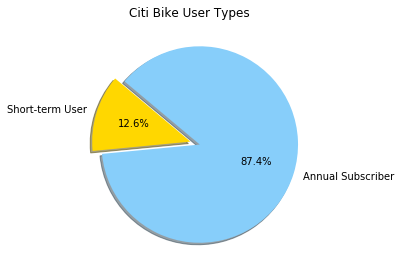

In [31]:
# Data to plot
labels = 'Short-term User', 'Annual Subscriber'
num_users = [358723,2481705]
colors = ['gold','lightskyblue']
explode = (0.1, 0)  # explode 1st slice
 
# Plot
plt.pie(num_users, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.suptitle('Citi Bike User Types', fontsize=12)

Are the bikes 'migrating' to certain stations as relatively more trips end at those stations? From the perspective of the program operator, having bikes accumulate would require a system to return them from: stations at which relatively more trips end, and to: stations from which relatively more trips begin. Let us calculate how frequently each station is used as a start station and as a stop station.

In [3]:
start_count = df2016.groupby('start station id').count().iloc[:,0]
stop_count = df2016.groupby('end station id').count().iloc[:,0]
df_start_stop = pd.DataFrame(start_count)
df_start_stop.columns = ['Start Count']
df_start_stop = df_start_stop.join(stop_count)
df_start_stop.columns = ['Start Count','Stop Count']
df_start_stop.head()

,Start Count,Stop Count
start station id,,
72,7633,7589
79,5929,5974
82,2632,2597
83,2895,3266
116,12930,13106


Summing the two columns:

In [22]:
df_start_stop.sum()

Start Count    2840428
Stop Count     2840398
dtype: int64

Since the sum of the two columns is almost the same, the system is essentially "closed." Very few bikes are leaving the system - in this case, only 30 out of 2,840,428. Those bikes may require repair, or be stolen, or possibly are not logged in to an end station because they were out in use when the start and stop counts were taken.

In [4]:
df_start_stop['Deficit'] = df_start_stop['Start Count'] - df_start_stop['Stop Count']
df_start_stop.head()

,Start Count,Stop Count,Deficit
start station id,,,
72,7633,7589,44
79,5929,5974,-45
82,2632,2597,35
83,2895,3266,-371
116,12930,13106,-176


Since the system is closed, we can see from the chart above that the bikes are migrating, because certain stations are running deficits (being used more often as a start station than a stop station) and other stations are running surpluses (collecting bikes because they are being used more often as a stop station than a start station). 
The system operator will have to round up bikes from stations running surpluses and return them to stations runing deficits, because user behavior alone is creating and not eliminating surpluses and deficits. 
How many bikes would the operator need to relocate in this two-month period?

In [24]:
df_start_stop['Deficit'].abs().sum()

107068

This experiment intends to explore this curious migration effect, in which some stations will run out of bikes and others will overflow, unless the bikes are re-allocated by the system operator.
Insights gained from changing the numbers of bikes at each station will be useful to the system operator in the future as it develops or improves an algorithm that most efficiently allocates and re-distribute bikes between stations.
With further experimentation, it should be possible to develop an algorithm to most efficiently reallocate bikes during the day, based on the time of day, predicted user behavior, and the magnitude and direction of the migration effect at each station. The algorithm will instruct the system operator from which station to pick up bikes at a given time and to which station to return them.
Initially, we will test adding bikes at a single location in a controlled experiment.

## Hypothesis

Our hypothesis is that adding bikes to a given bike station at the beginning of the day (before peak commuter time) will increase the use of that station as a start station. The null hypothesis is that adding bikes to a given station at the beginning of the day has no effect on the use of that station as a start station.

## Design of the Experiment

The experiment will use eight stations, selected based on having: a high deficit, many users, few users, and a high surplus. By selecting two stations in each of the four categories, we will be able to observe the presence or absence of an effect from adding bikes in each situation and have two stations to reduce random effects relative to only selecting one station. Specifically, we will rank order the stations in four different ways in order to select the stations. First, the stations with a high deficit:

In [30]:
df_start_stop.sort_values('Deficit',ascending=False).head(2)

,Start Count,Stop Count,Deficit
start station id,,,
3230,12464,7192,5272
3236,9323,4725,4598


Second, the stations with many users:

In [7]:
df_start_stop.sort_values('Start Count',ascending=False).head(2)

,Start Count,Stop Count,Deficit
start station id,,,
519,29605,29034,571
426,23525,23630,-105


Third, the stations with few users:

In [8]:
df_start_stop.sort_values('Start Count',ascending=True).head(2)

,Start Count,Stop Count,Deficit
start station id,,,
3036,2,2,0
3017,3,56,-53


Fourth, the stations with a high surplus:

In [9]:
df_start_stop.sort_values('Deficit',ascending=True).head(2)

,Start Count,Stop Count,Deficit
start station id,,,
432,12618,15403,-2785
492,11961,13858,-1897


Accordingly, the eight stations selected for the experiment will be: 3230, 3236, 519, 426, 3036, 3017, 432, and 492. 
We will add a number of bikes equal to the mean daily positive bike deficit for the stations during June and July of 2016, so that our choice of the number of bikes added is derived from prior observation.

In [33]:
selector = df_start_stop.Deficit.map(lambda x:x>0)
df_deficit_positive = df_start_stop.loc[selector,:]
bikes_to_add = df_deficit_positive.Deficit.mean()/60
print(int(bikes_to_add))

4


We will add the four bikes at 5:30am (when very few users are present), in order to minimize the impact of the experimental process on user behavior. 
We will add the bikes on alternate days during a 14-day period - chosen so that both the test (A) and control (B) groups will be measured on each of the days of the week an even number of times. 
We will conduct the experiment as an A/B Test, with the experiment group being riders departing the station on the 7 days on which bikes are added, and the control group being riders departing the station on the 7 days on which bikes are not added.
We will also measure the same stations in the 14-day period following the experiment, with the A group receiving no treatment and the B group being a control, as a further check on the validity of the experimental method.

## Analysis Plan

We will measure start station (ridership) for the A-group and the B-group in each of the four categories and both of the 14-day periods, and compare using a T-test and p-value to see if any change in ridership is statistically-significant or is instead due to random noise in the underlying data (daily fluctuations in ridership). A p-value less than 0.05 in a two-tailed t-test will falsify the null hypothesis that adding bikes has no effect on the use of a given station as a start station.